In [8]:
import numpy as np
from numpy import eye, array, asarray
from numpy.linalg import inv
from numpy.random import randn
import math
from math import sqrt
import matplotlib.pyplot as plt

In [9]:
class KalmanFilter:
    def __init__(self):
        self.M = None
        self.H = None
        self.mu = None
        self.Sigma = None
        self.Sigma_y = None
        self.Q = None
        
    def predict_response(self):
        return self.H @ self.mu
    
    # KF assimilation
    def update(self, y_t):
        # Predict y to measure innovation
        y_hat = self.predict_response()
        # Calculate Kalman gain
        K = self.Sigma @ self.H.T @ inv(self.H @ self.Sigma @ self.H.T + self.Sigma_y)
        # Update belief
        I = np.identity(self.mu.size)
        self.mu = self.mu + K @ (y_t - y_hat)
        self.Sigma = (I-K@self.H)@self.Sigma
    
    # time dynamics
    def predict(self):
        self.mu = self.M @ self.mu
        self.Sigma = self.M @ self.Sigma @ self.M.T + self.Q

In [10]:
class ExtendedKalmanFilter(KalmanFilter):
    def __init__(self):
        super().__init__()
        self.h = None
        self.h_jacobian_at_x = None
    
    def predict_response(self):
        self.H = self.h_jacobian_at_x(self.mu)
        return self.h(self.mu)

In [11]:
class RadarSim(object):
    """ Simulates the radar signal returns from an object flying 
    at a constant altityude and velocity in 1D. 
    """
    
    def __init__(self, dt, pos, vel, alt):
        self.pos = pos
        self.vel = vel
        self.alt = alt
        self.dt = dt
        
    def get_range(self):
        """ Returns slant range to the object. Call once for each
        new measurement at dt time from last call.
        """
        
        # add some process noise to the system
        self.vel = self.vel  + .1*randn()
        self.alt = self.alt + .1*randn()
        self.pos = self.pos + self.vel*self.dt
    
        # add measurement noise
        err = self.pos * 0.05*randn()
        slant_dist = math.sqrt(self.pos**2 + self.alt**2)
        
        return slant_dist + err


def h_jacobian_at(x):
    """ compute Jacobian of H matrix for state x """

    horiz_dist = x[0]
    altitude   = x[2]
    denom = sqrt(horiz_dist**2 + altitude**2)
    return array ([[horiz_dist/denom, 0., altitude/denom]])


def hx(x):
    """ compute measurement for slant range that would correspond 
    to state x.
    """
    
    return (x[0]**2 + x[2]**2) ** 0.5

In [12]:
# create radar object
dt = 0.05
radar = RadarSim(dt, pos=0., vel=100., alt=1000.)
# initialize ekf
ekf = ExtendedKalmanFilter()
# prior
ekf.mu = array([radar.pos-100, radar.vel+100, radar.alt+1000])
ekf.Sigma = eye(3)*50
# Time dynamics from linear approximation
ekf.M = eye(3) + array([[0, 1, 0],
                       [0, 0, 0],
                       [0, 0, 0]])*dt
ekf.Q = array([[0, 0, 0],
              [0, 1, 0],
              [0, 0, 1]]) * 0.001
# Observation noise and maps
ekf.Sigma_y = radar.alt * 0.05 # 5% of distance
ekf.h = hx
ekf.h_jacobian_at_x = h_jacobian_at

In [13]:
# Assimilate over time
xs = []
track = []
for t in range(int(20/dt)):
    #mu_prior.append(kf.mu[0])
    # assimilation step
    y = radar.get_range()
    track.append((radar.pos, radar.vel, radar.alt))
    ekf.update(array([y]))
    #mu_posterior.append(kf.mu[0])
    # time dynamics for next iteration
    xs.append(ekf.mu)
    ekf.predict()

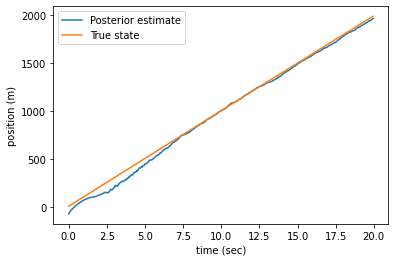

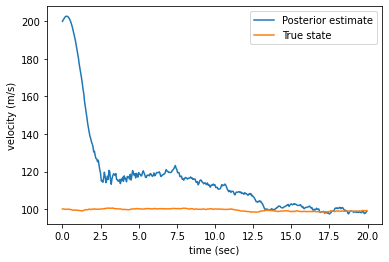

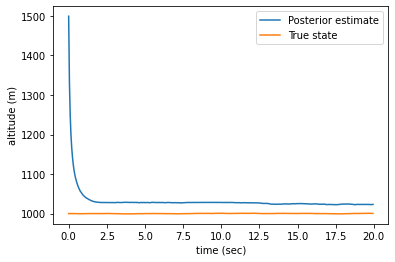

In [14]:
# Inspect
xs = asarray(xs)
track = asarray(track)
time = np.arange(0, len(xs)*dt, dt)
plot1 = plt.figure(1)
plt.plot(time, xs[:,0])
plt.plot(time, track[:,0])
plt.ylabel("position (m)")
plt.xlabel("time (sec)")
plt.legend(['Posterior estimate', "True state"])
plt.show()

plot2 = plt.figure(2)
plt.plot(time, xs[:,1])
plt.plot(time, track[:,1])
plt.ylabel("velocity (m/s)")
plt.xlabel("time (sec)")
plt.legend(['Posterior estimate', "True state"])
plt.show()

plot3 = plt.figure(3)
plt.plot(time, xs[:,2])
plt.plot(time, track[:,2])
plt.ylabel("altitude (m)")
plt.xlabel("time (sec)")
plt.legend(['Posterior estimate', "True state"])
plt.show()